In [1]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import iirpeak, iirnotch
from IPython.display import Audio
from scipy.signal import freqz
import matplotlib.pyplot as plt

Za početak, trebamo generisati testni audio fajl koji ćemo koristiti u nastavku pri obradi, kao što je traženo tekstom zadatka. Za generisanje koristićemo sinusne signale, tj. generisaćemo složenoperidočni sinusni signal. Signal će imati 10 harmonika, osnovne freknvencije 262 Hz, dužina trajanja signala je 3 sekunde, a frekvencija odmjeravanja 11025 Hz.

In [2]:
#frequency = 262 # Hz
frequency = 131 
duration = 3 # seconds
sampling_rate = 11025 # samples per seconds

time = np.linspace(0, duration, int(sampling_rate * duration), endpoint = False)

audio_signal1 = np.sin(2 * np.pi * 1*frequency * time)
audio_signal2 = np.sin(2 * np.pi * 2*frequency * time)
audio_signal3 = np.sin(2 * np.pi * 4*frequency * time)
audio_signal4 = np.sin(2 * np.pi * 5*frequency * time)
audio_signal5 = np.sin(2 * np.pi * 7*frequency * time)
audio_signal6 = np.sin(2 * np.pi * 10*frequency * time)
audio_signal7 = np.sin(2 * np.pi * 11*frequency * time)
audio_signal8 = np.sin(2 * np.pi * 12*frequency * time)
audio_signal9 = np.sin(2 * np.pi * 13*frequency * time)
audio_signal10 = np.sin(2 * np.pi * 14*frequency * time)

audio_signal = audio_signal1 + 3 * audio_signal2 + 0.5 * audio_signal3 + 0.1 * audio_signal4 + 1.2 * audio_signal5 + 2 * audio_signal6
+ 0.5 * audio_signal7 + 0.1 * audio_signal8 + 1.2 * audio_signal9 + 0.25 * audio_signal10

wavfile.write('audio.wav', sampling_rate, audio_signal)

In [3]:
Fs, x = wavfile.read('testni_audio_uzorci/audio.wav')
Audio(x, rate=Fs)

Neki podaci o signalu

In [4]:
print(len(x))
print(Fs)

33075
11025


Nakon generisanja testnog audio signala, za rad u CrossCore Embedded Studio alatu, potrebno ga je eksportovati u vidu .h fajla. To je urađeno sljedećim dijelom koda.

In [13]:
f = open("testni_audio_uzorci/test_audio.h", "w")
f.write("#define LEN 33075\n")
f.write("const float test_signal[LEN] = {\n\t")
for i in range(len(x)):
    f.write("%.8f, " % x[i])
    if((i+1) % 5 == 0):
        f.write("\n\t")  
f.write("};")
f.write("\n")

1

===========================================================================================

### Implementacija prvog audio efekta - delay (kašnjenje)
Ovaj audio efekat spada u grupu efekata zasnovanih na kašnjenju, odatle i njegov naziv. Zapravo to je jedan od najjednostavnijih i u suštini osnovni efekat iz ove grupe, većina drugih efekata je zasnovana na njemu. Za realizaciju može se koristiti FIR filtar i ova realizacija biće korištena u slučaju ovog projektnog zadatka. Za realizaciju ovog efekta koristi se jednačina diferencija na osnovu koje se onda programski može jednostavno realizovati efekat y(n) = x(n) - g * x(n-M).  

Iz jednačine diferencija može se vidjeti da postoje dva parametra pri realizaciji, a to su M i g. Parametar M označava broj odmjeraka za koji je signal zakašnjen iz relacije M = t * Fs , gdje je t vrijeme kašnjenja signala u sekundama, a Fs frekvencija odmjeravanja, dok je g faktor pojačanja zakašnjelog signala, tj. često se kaže odnos amplituda reflektovanog i direktnog signala. Obično uzima vrijednosti između 0 i 1.

Za potrebe našeg projektnog zadatka smješten je u Grupu 1 - Manje zahtjevni filtri.

In [5]:
def delay(x, M, g):
    x_delay = np.zeros(len(x))
    # popunjavanje niza koji predstavlja zakašnjenu verziju originala
    x_delay[M:] = x[:-M]
    # računanje izlaza kao kombinacije ulaza i oslabljenog zakašnjenog signala
    y = x + g * x_delay
    return y

In [6]:
Fs, x = wavfile.read('testni_audio_uzorci/audio.wav')
y = delay(x, int(0.1*Fs), 0.5)
Audio(y, rate=Fs)

Upisivanje rezultata primjene efekta na signal audio.wav u fajl rezultati/delay/python.txt, za kasnije korištenje u testiranje.

In [9]:
f = open("rezultati/delay/python.txt", "w")
for i in range(len(y)):
    f.write("%f\n" % y[i])
f.close()

Provjera na zvučnom uzorku 'acoustic.wav'.

In [9]:
Fs, x = wavfile.read('acoustic.wav')
y = delay(x, int(0.1*Fs), 0.5)
Audio(y, rate=Fs)

===========================================================================================

### Implementacija drugog efekta - distortion (distorzija)
Efekat distorzije spada u grupu efekata sa nelinearnom obradom. Termin nelinearna obrada podrazumijeva sve algoritme obrade signala koji ne zadovoljavaju princip linearnosti. Ono što rade nelinearni algoritmi obrade, jeste da unose dodatne spektralne frekvencijske komponente kojih nema u originalnom signalu. A za slučaj audio signala, to znači da će se promijeniti boja zvuka, što slušalac može jasno da čuje. U suštini ono što distorzija radi ulaznom signalu jeste da ga nelinearno transformiše tzv. nelinearnom krivom pojačanja. Konkretno kod efekta distorzije ta kriva je obično neka verzija eksponencijalne krive i postoji nekoliko funkcija kojim se može izvršiti distorzija. Jedna od najčešće korišćenih i ona koja je korištena u ovom zadatku je sljedeća $$y(n) = \frac {x} {|x|}(1 - e ^ {- \frac {x ^ 2}{|x|}} ) $$    

Osnovni parametri distorzije su pojačanje i miks. Prije primjene funkcije iznad, na ulazni signal, potrebno ga je pojačati određenim pojačanjem. Što se tiče miksa to je obično drugi podesivi parametar distorzije i on određuje koliko će u rezultatnom signalu biti udjela originalnog signala, a koliko obrađenog, po principu (1 – mix) * original + mix * obrađeni. Dakle miks ima vrijednost između 0 i 1. Često prije obrade radi normalizacija signala, kao i normalizacija konačnog obrađenog signala, da bi se izbjegla dodatna izobličenja uzrokovana odsjecanjem audio signala, zbog toga što izlazi izvan opsega vrijednosti koje je moguće fizički reprodukovati na zvučniku.

In [10]:
def distortion(x, gain, mix):
    x = x / np.max(np.abs(x))       # normalizacija ulaza
    x_gain = gain * x               # prvo pojačavamo ulazni signal
    # a zatim ga propuštamo kroz funkciju distorzije
    x_dist = np.sign(x_gain) * (1 - np.exp(-np.sign(x_gain) * x_gain))
    # miksanje originala i obrađenog niza
    y = (1-mix) * x + mix * x_dist  
    # normalizacija na izlazu
    y = y / np.max(np.abs(x))
    return y

In [11]:
Fs, x = wavfile.read('testni_audio_uzorci/audio.wav')
y = distortion(x, 20, 0.8)
Audio(y, rate=Fs)

Upisivanje rezultata primjene efekta na signal audio.wav u fajl rezultati/distortion.txt, za kasnije korištenje u CCES.

In [12]:
f = open("rezultati/distortion/python.txt", "w")
for i in range(len(y)):
    f.write("%f\n" % y[i])

Provjera na zvučnom uzorku 'acoustic.wav'.

In [14]:
Fs, x = wavfile.read('testni_audio_uzorci/acoustic.wav')
y = distortion(x, 20, 0.8)
Audio(y, rate=Fs)

===========================================================================================

### Implementacija trećeg efekta - wah-efekat. 
Ovaj efekat je dobio ime po tome, što kada se primjeni na neki audio signal u tom audio signalu pojavi se zvuk sličan zvuku koji se dobije izgovaranjem riječi 'wah'. Spada u grupu efekata sa vremenski promjenljivim filtrima. 

In [19]:
def wah_wah(x):
    # parametri efekta
    minf = 500
    maxf = 3000
    Fw = 2000
    delta = Fw/Fs
    # kreiranje niskofrekventnog oscilatora
    Fc = np.arange(minf, maxf, delta)
    
    while len(Fc) < len(x):
        Fc = np.concatenate((Fc, np.arange(maxf, minf, -delta)))
        Fc = np.concatenate((Fc, np.arange(minf, maxf, delta)))

    # niz Fc sadrži trougaoni signal vrijednosti izmedju minf i maxf       
    Fc = np.array(Fc[:len(x)])    
    Q = 2

    # kreiranje fajlova u koje ce biti smjesteni koeficijenti filtara
    f1 = open("filtri/iir_peak_a.h", "w")
    f1.write("float a_coeff[] = {\n\t")
    f2 = open("filtri/iir_peak_b.h", "w")
    f2.write("float b_coeff[] = {\n\t")

    # racunanje vrijednosti filtara i upisivanje u fajlove 
    for n in np.arange(2, len(x)):
        b, a = iirpeak(2*Fc[n]/Fs, Q)
        for i in range(0, 3):
            f1.write("%f, " % a[i])
            f2.write("%f, " % b[i])
        f1.write("\n\t")
        f2.write("\n\t")
 
    f1.write("\n};")
    f2.write("\n};")


    y = np.zeros(x.shape)
    
    # racunanje koeficijenata filtra i na osnovu koeficijenata i ulaznog odmjerka
    # racunanje izlaznog odmjerka
    for n in np.arange(2, len(x)):
        b, a = iirpeak(2*Fc[n]/Fs, Q)
        y[n] = b[0]*x[n] + b[1]*x[n-1] + b[2]*x[n-2] - a[1]*y[n-1] - a[2]*y[n-2] 
    
    return y

In [44]:
Fs, x = wavfile.read('testni_audio_uzorci/audio.wav')
y = wah_wah(x)
Audio(y, rate=Fs)

Upisivanje rezultata primjene efekta na signal audio.wav u fajl rezultati/wah_wah/python.txt, za kasnije korištenje u testiranje.

In [47]:
f = open("rezultati/wah_wah/python.txt", "w")
for i in range(len(y)):
    f.write("%f\n" % y[i])

Provjera na zvučnom uzorku 'acoustic.wav'.

In [22]:
Fs, x = wavfile.read('testni_audio_uzorci/acoustic.wav')
y = wah_wah(x)
Audio(y, rate=Fs)

===========================================================================================

### Imlementacija četvrtog efekta - phaser (fejzer)
Efekata jako sličan prethodnom efektu, barem prema implementaciji. Kao i 'wah-wah' efekat pripada grupi efekata sa vremenski promjenljivim filtrima, a razlika je u tome što se kod 'wah-wah' efekta koristi filtar propusnik opsega, dok se kod fejzera koristi filtar nepropusnik opsega odnosno konkretno tzv. 'notch' filtar. 

In [23]:
def phaser(x):
    minf = 500
    maxf = 3000
    Fw = 2000
    delta = Fw/Fs
    Fc = np.arange(minf, maxf, delta)
    while len(Fc) < len(x):
        Fc = np.concatenate((Fc, np.arange(maxf, minf, -delta)))
        Fc = np.concatenate((Fc, np.arange(minf, maxf, delta)))
        
    Fc = np.array(Fc[:len(x)])

    f1 = open("filtri/iir_notch_a.h", "w")
    f1.write("float notch_a_coeff[] = {\n\t")
    f2 = open("filtri/iir_notch_b.h", "w")
    f2.write("float notch_b_coeff[] = {\n\t")

    for n in np.arange(2, len(x)):
        b, a = iirnotch(2*Fc[n]/Fs, 1)
        for i in range(0, 3):
            f1.write("%f, " % a[i])
            f2.write("%f, " % b[i])
        f1.write("\n\t")
        f2.write("\n\t")
    
    f1.write("\n};")
    f2.write("\n};")


    y = np.zeros(x.shape)
    for n in np.arange(2, len(x)):
        b, a = iirnotch(2*Fc[n]/Fs, 1)
        y[n] = b[0]*x[n] + b[1]*x[n-1] + b[2]*x[n-2] - a[1]*y[n-1] - a[2]*y[n-2]

    x = y
    y = np.zeros(x.shape)
    for n in np.arange(2, len(x)):
        b, a = iirnotch(2*Fc[n]/Fs, 1)
        y[n] = b[0]*x[n] + b[1]*x[n-1] + b[2]*x[n-2] - a[1]*y[n-1] - a[2]*y[n-2]

    return y

Provjera na zvučnom uzorku 'acoustic.wav'.

In [24]:
Fs, x = wavfile.read('testni_audio_uzorci/acoustic.wav')
y = phaser(x)
Audio(y, rate=Fs)

In [25]:
Fs, x = wavfile.read('testni_audio_uzorci/audio.wav')
y = phaser(x)
Audio(y, rate=Fs)

Upisivanje rezultata primjene efekta na signal audio.wav u fajl rezultati/phaser/python.txt, za kasnije korištenje u testiranje.

In [26]:
f = open("rezultati/phaser/phaser.txt", "w")
for i in range(len(y)):
    f.write("%f\n" % y[i])

===========================================================================================

### Implementacija petog efekta - reverberation (reverberacije)
Reverberacije je efekat koji spada u grupu tzv. prostornih efekata. Javlja se kao posljedica mnogobrojnih refleksija zvučnih talasa u zatvorenom prostoru koji se vraćaju do slušaoca i sabiraju sa audio signalom koji je direktno došao do slušaoca bez refleksija i tako zvuku daju prostorni osjećaj. U tekstu našeg projektnog zadatka navedeni su u grupi specijalnih efekata. 

In [52]:
def reverb(x, alpha, N, R):
    y = np.zeros(len(x))
    # prolazak kroz sve odmjerke
    for n in range(len(x)):
        # kreiranje N refleksija za dati odmjerak
        for k in range(N):
            y[n] += ((alpha ** k) * (x[n - k*R] if (n - k*R) > 0 else 0))

    # normalizacija
    y = y / np.max(np.abs(x))

    return y

In [53]:
Fs, x = wavfile.read('testni_audio_uzorci/audio.wav')
y = reverb(x, 0.8, 10, 8)
Audio(y, rate=Fs)

Upisivanje rezultata primjene efekta na signal audio.wav u fajl rezultati/reverb.txt, za kasnije korištenje u CCES.

In [57]:
f = open("rezultati/reverb/python.txt", "w")
for i in range(len(y)):
    f.write("%f\n" % y[i])

Provjera na zvučnom uzorku 'acoustic.wav'.

In [32]:
Fs, x = wavfile.read('testni_audio_uzorci/acoustic.wav')
y = reverb(x, 0.8, 10, 8)
Audio(y, rate=Fs)

===========================================================================================

Testiranje rezultata.  
U jedan niz učitaćemo rezultatni signal dobijem obradom u python-u, a u drugi signal dobijen obradom u cces. Zatim ćemo razliku ta dva signala prikazati na grafiku.  
I tako za svaki efekat. 

### 1. Delay efekat

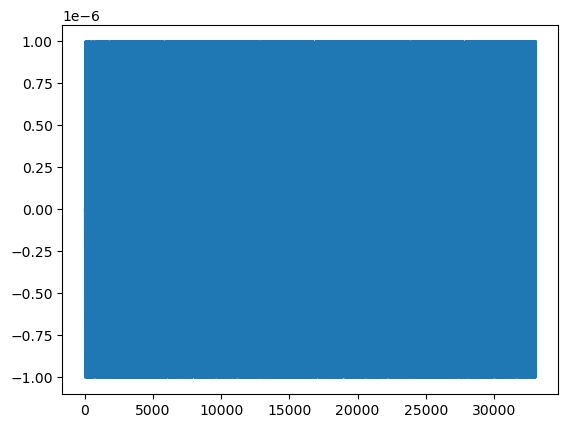

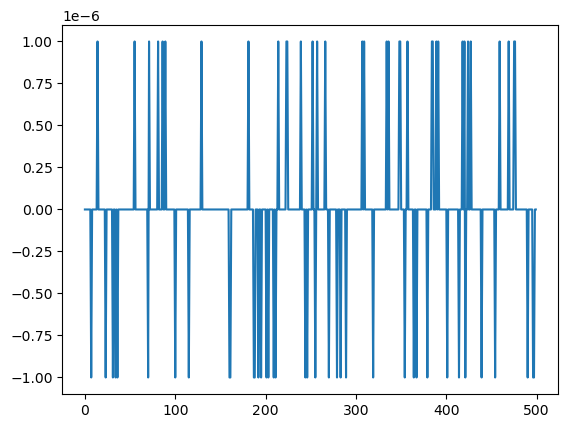

In [62]:
file_path1 = "rezultati/delay/python.txt"
f1 = open(file_path1, "r")
temp1 = f1.readlines()
f1.close()
test1 = np.array(temp, dtype=float)

file_path2 = "rezultati/delay/cces.txt"
f2 = open(file_path2, "r")
temp2 = f2.readlines()
f2.close()
test2 = np.array(temp2, dtype=float)

plt.figure()
plt.plot(test1 - test2)
plt.figure()
plt.plot((test1 - test2)[10000:10500])

### 2. Distortion efekat

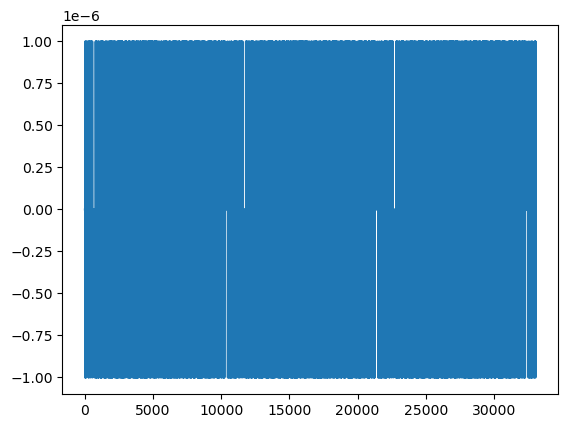

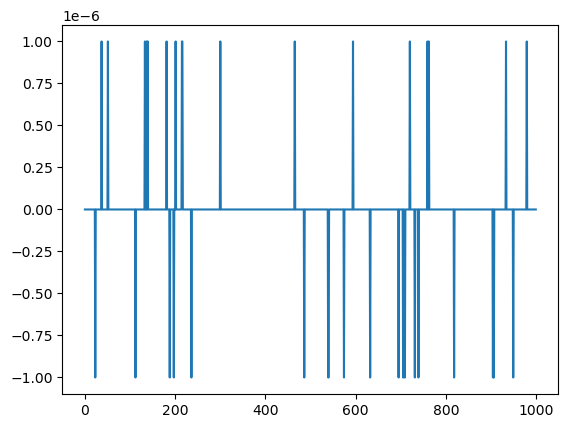

In [61]:
file_path1 = "rezultati/distortion/python.txt"
f1 = open(file_path1, "r")
temp1 = f1.readlines()
f1.close()
test1 = np.array(temp1, dtype=float)

file_path2 = "rezultati/distortion/cces.txt"
f2 = open(file_path2, "r")
temp2 = f2.readlines()
f2.close()
test2 = np.array(temp2, dtype=float)

plt.figure()
plt.plot(test1 - test2)
plt.figure()
plt.plot((test1 - test2)[10000:11000])

### 3. Wah-Wah efekat

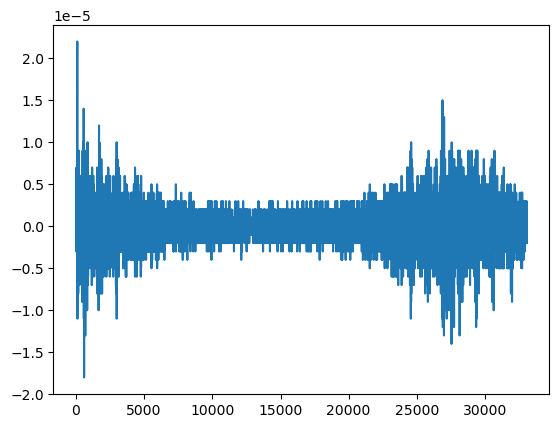

In [48]:
file_path1 = "rezultati/wah_wah/python.txt"
f1 = open(file_path1, "r")
temp1 = f1.readlines()
f1.close()
test1 = np.array(temp1, dtype=float)

file_path2 = "rezultati/wah_wah/cces.txt"
f2 = open(file_path2, "r")
temp2 = f2.readlines()
f2.close()
test2 = np.array(temp2, dtype=float)

plt.figure()
plt.plot(test1 - test2)

### 4. Phaser efekat

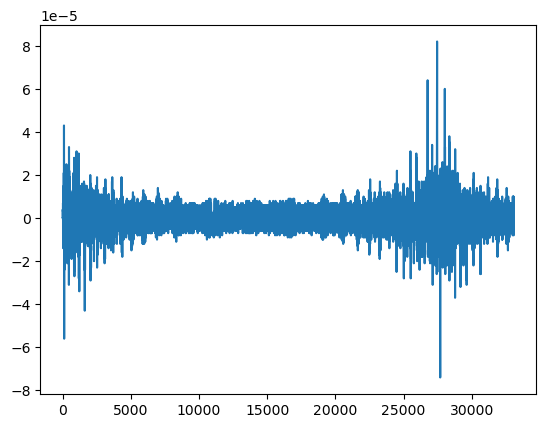

In [50]:
file_path1 = "rezultati/phaser/python.txt"
f1 = open(file_path1, "r")
temp1 = f1.readlines()
f1.close()
test1 = np.array(temp1, dtype=float)

file_path2 = "rezultati/phaser/cces.txt"
f2 = open(file_path2, "r")
temp2 = f2.readlines()
f2.close()
test2 = np.array(temp2, dtype=float)

plt.figure()
plt.plot(test1 - test2)

### 5. Reverb efekat

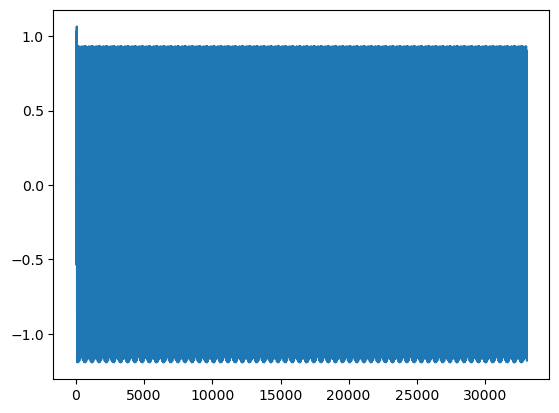

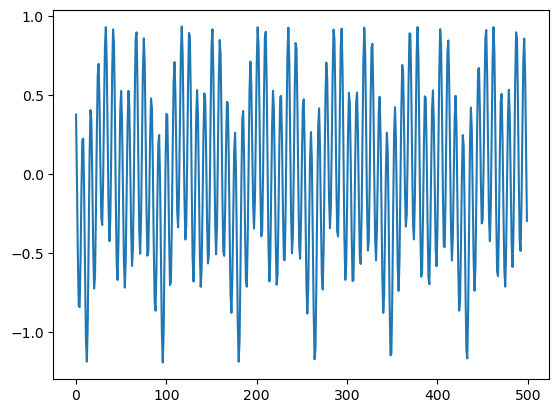

In [59]:
file_path1 = "rezultati/reverb/python.txt"
f1 = open(file_path1, "r")
temp1 = f1.readlines()
f1.close()
test1 = np.array(temp1, dtype=float)

file_path2 = "rezultati/reverb/cces.txt"
f2 = open(file_path2, "r")
temp2 = f2.readlines()
f2.close()
test2 = np.array(temp2, dtype=float)

plt.figure()
plt.plot(test1 - test2)
plt.figure()
plt.plot((test1 - test2)[10000:10500])